In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure
import pickle as pkl

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics")
from compute_metrics import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
def plot_results(result_df):
    result_df.loc[result_df['score_type']=='FID', 'score'] = 1 / result_df.loc[result_df['score_type']=='FID', 'score']
    result_df.loc[result_df['score_type']=='FID', 'score_type'] = u'FID\u207B\u00B9'
    
    plt.figure(figsize=(15,15))
    ax = sns.barplot(data=result_df,
                        x='score',
                        y='score_type',
                        hue='model',
                        palette='Paired',
                        orient='h')
        
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    # plt.xlabel('Metric value (\u2193)', fontsize=40)
    plt.xlabel('metric value (higher better)', fontsize=40)
    plt.ylabel('metric type', fontsize=40)
    plt.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size': 28})
    plt.title('Evaluation metrics predictions on BBBC021', fontsize=40)
    plt.show()
    plt.savefig('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/plots/benchmark_scores_final.svg',
               dpi=300, bbox_inches='tight', format='svg')

In [3]:
def process_score(df, process_acc=True):
    df.loc[df['score_type']=='FID', 'score'] = 1 / df.loc[df['score_type']=='FID', 'score']
    df.loc[df['score_type']=='FID', 'score_type'] = u'FID\u207B\u00B9'
    if process_acc:
        df.loc[df['score_type']=='Accuracy', 'score'] = 1 -  df.loc[df['score_type']=='Accuracy', 'score']
    return df

In [4]:
results_impa = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/results/IMPA/bbbc021_try.pkl')
results_impa['dataset'] = 'IMPA'
results_stargan = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/results/starGANv1/bbbc021_try.pkl')
results_stargan['dataset'] = 'StarGANv1'
results_stargan['model'] = 'StarGANv1'
results_starganv2 = pd.read_pickle('/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_stargan_six2.pkl')
results_starganv2['dataset'] = 'StarGANv2'
results_starganv2['model'] = 'StarGANv2'
results_drit = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/results/DRIT++/bbbc021_try.pkl')
results_drit['dataset'] = 'DRIT++'
results_dmit = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/results/DMIT/bbbc021_try.pkl')
results_dmit['dataset'] = 'DMIT'
results_baseline = pd.read_pickle('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/results/baseline/bbbc021_try.pkl')
results_baseline['dataset'] = 'Baseline'

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_starganv2.pkl", "rb") as file:
    metrics_starGANv2 = pkl.load(file)

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_retrain.pkl", "rb") as file:
    metrics_IMPA = pkl.load(file)

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics/results_phendiff/results_bbbbc021.pkl", "rb") as file:
    metrics_phendiff = pkl.load(file)

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics/results_stytr/results_bbbbc021.pkl", "rb") as file:
    metrics_stytr = pkl.load(file)

In [8]:
# results_impa = results_impa.replace('Density', 'density')
# results_impa = results_impa.replace('Coverage', 'coverage')
results_impa = results_impa.replace('1-Accuracy', 'Accuracy')
results_impa = process_score(results_impa, process_acc=True)

# results_stargan = results_stargan.replace('Density', 'density')
# results_stargan = results_stargan.replace('Coverage', 'coverage')
results_stargan = results_stargan.replace('1-Accuracy', 'Accuracy')
results_stargan = process_score(results_stargan, process_acc=True)

# results_starganv2 = results_starganv2.replace('Density', 'density')
# results_starganv2 = results_starganv2.replace('Coverage', 'coverage')
results_starganv2 = results_starganv2.replace('Accuracy', 'Accuracy')
results_starganv2 = process_score(results_starganv2, process_acc=False)

results_phendiff = metrics_phendiff
results_phendiff = results_phendiff.replace('coverage', 'Coverage')
results_phendiff = results_phendiff.replace('accuracy', 'Accuracy')
results_phendiff = process_score(results_phendiff, process_acc=False)

results_stytr = metrics_stytr
results_stytr = results_stytr.replace('coverage', 'Coverage')
results_stytr = results_stytr.replace('accuracy', 'Accuracy')
results_stytr = process_score(results_stytr, process_acc=False)

# results_drit = results_drit.replace('Density', 'density')
# results_drit = results_drit.replace('Coverage', 'coverage')
results_drit = results_drit.replace('1-Accuracy', 'Accuracy')
results_drit = process_score(results_drit, process_acc=True)

# results_dmit = results_dmit.replace('Density', 'density')
# results_dmit = results_dmit.replace('Coverage', 'coverage')
results_dmit = results_dmit.replace('1-Accuracy', 'Accuracy')
results_dmit = process_score(results_dmit, process_acc=True)

# results_baseline = results_baseline.replace('Density', 'density')
# results_baseline = results_baseline.replace('Coverage', 'coverage')
results_baseline = results_baseline.replace('1-Accuracy', 'Accuracy')
results_baseline = process_score(results_baseline, process_acc=True)

In [9]:
all_results = pd.concat([results_stytr,
                         results_phendiff,
                         results_baseline, 
                         results_drit, 
                         results_dmit, 
                         results_stargan, 
                         results_starganv2,
                         results_impa], axis=0)

In [10]:
all_results = all_results.loc[all_results.score_type!="Density"]

In [11]:
grouping = all_results.groupby('model', as_index=False).mean()
grouping['score_type']='Average'
grouping['mol'] = 'all'
grouping['dataset'] = grouping['model']

grouping

/tmp/ipykernel_2344997/1262519559.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouping = all_results.groupby('model', as_index=False).mean()


,model,score,run,score_type,mol,dataset
0,DMIT,0.946208,4.5,Average,all,DMIT
1,DRIT++,0.708345,4.5,Average,all,DRIT++
2,IMPA,0.917766,4.5,Average,all,IMPA
3,PhenDiff,0.425627,0.0,Average,all,PhenDiff
4,StarGANv1,0.719015,4.5,Average,all,StarGANv1
5,StarGANv2,0.935975,1.0,Average,all,StarGANv2
6,StyTR,0.496709,1.0,Average,all,StyTR
7,baseline,0.667912,4.5,Average,all,baseline


In [12]:
all_results=pd.concat([all_results, grouping])
all_results

,score,score_type,run,mol,model,dataset
0,1.381989,FID⁻¹,0.0,AZ138,StyTR,NaN
2,0.376154,Coverage,0.0,AZ138,StyTR,NaN
3,0.000000,Accuracy,0.0,AZ138,StyTR,NaN
4,0.951952,FID⁻¹,0.0,AZ258,StyTR,NaN
6,0.344423,Coverage,0.0,AZ258,StyTR,NaN
...,...,...,...,...,...,...
3,0.425627,Average,0.0,all,PhenDiff,PhenDiff
4,0.719015,Average,4.5,all,StarGANv1,StarGANv1
5,0.935975,Average,1.0,all,StarGANv2,StarGANv2
6,0.496709,Average,1.0,all,StyTR,StyTR


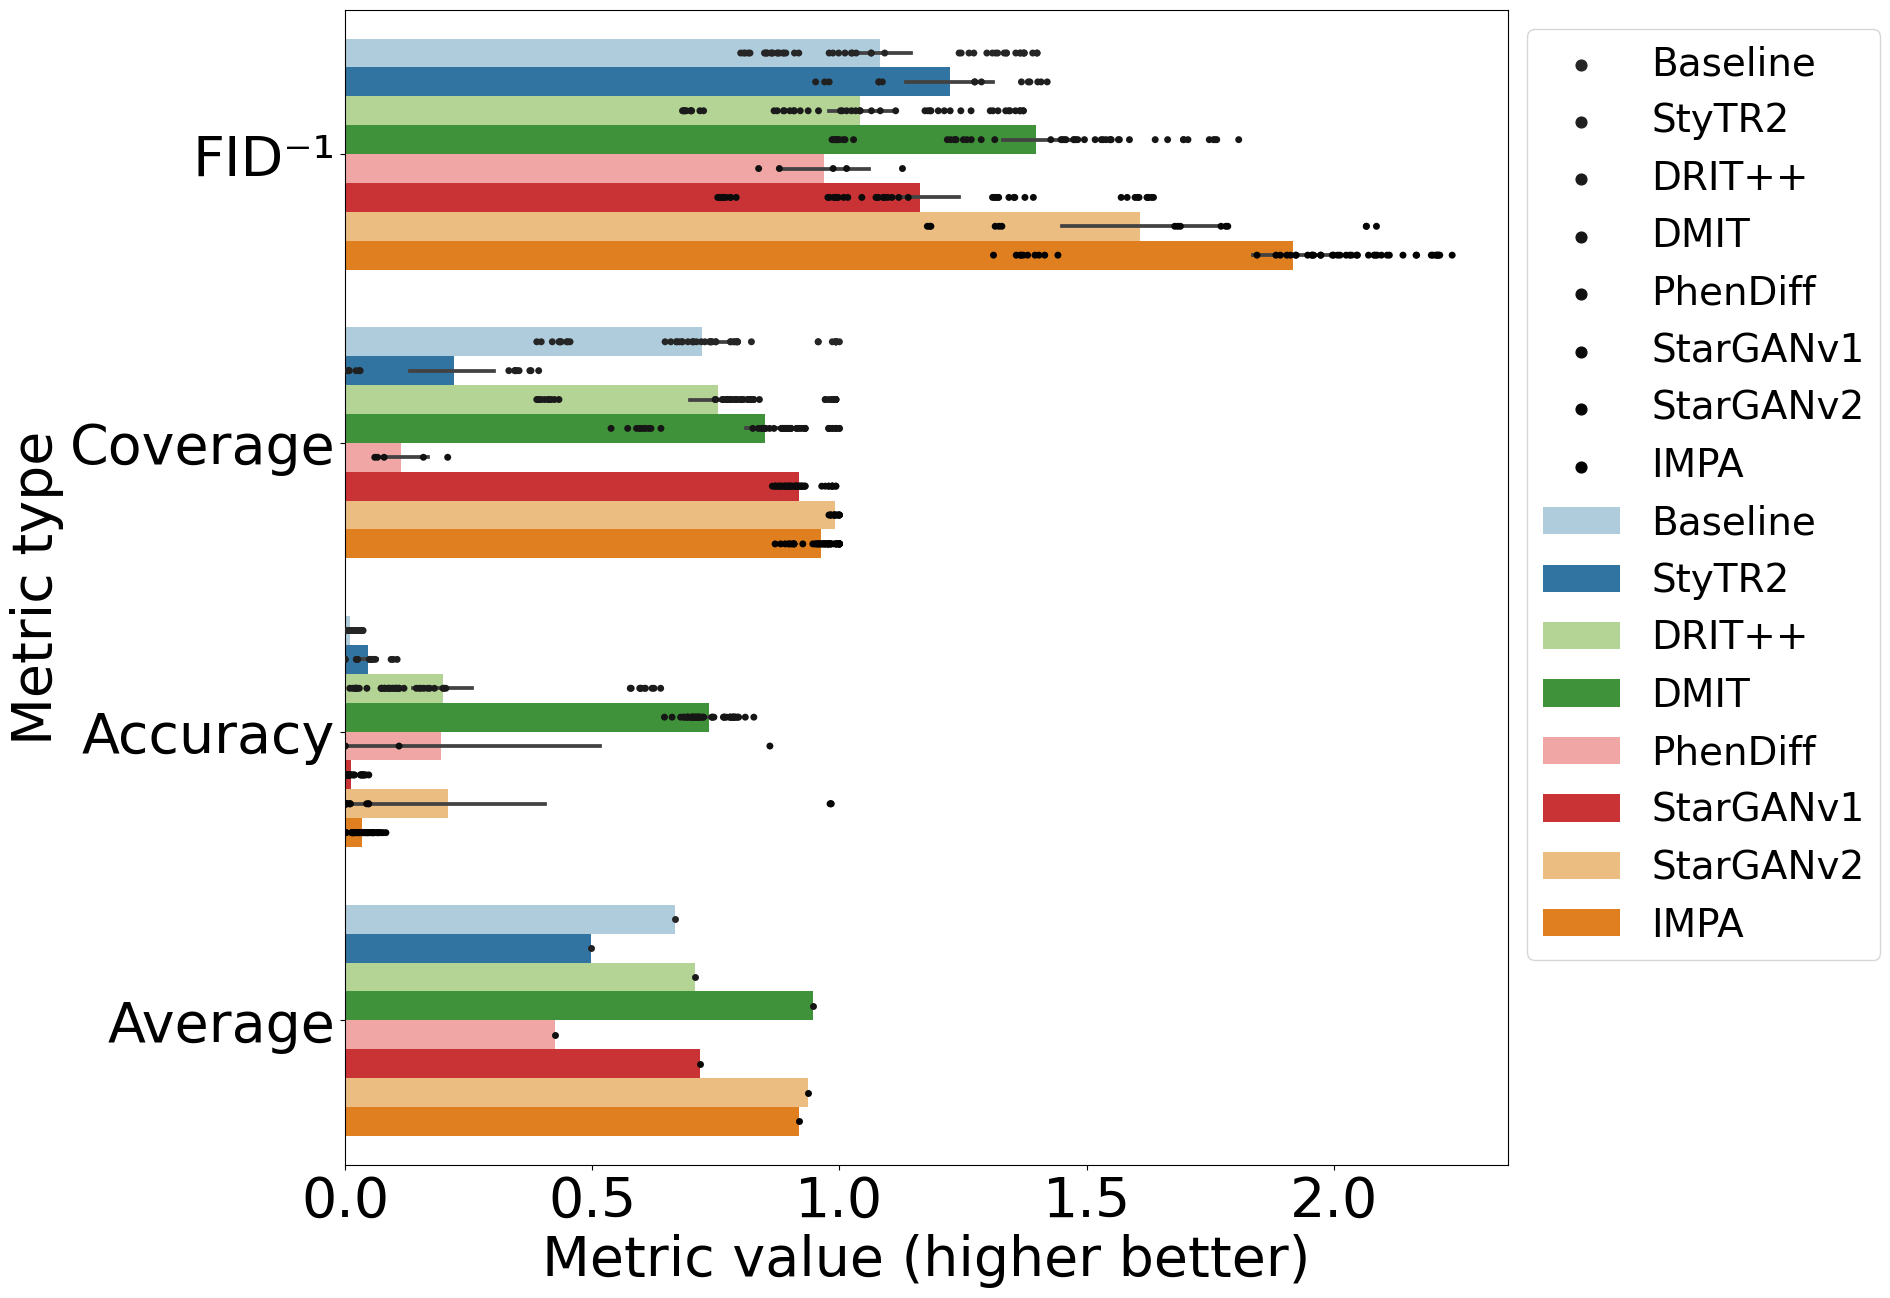

In [13]:
to_plot = ['FID\u207B\u00B9',  'Coverage', 'Accuracy', 'Average']
all_results = all_results.replace('baseline', 'Baseline')
all_results = all_results.replace('StyTR', 'StyTR2')


plt.figure(figsize=(15,15))
ax = sns.barplot(data=all_results.loc[all_results.score_type.isin(to_plot)],
                x='score',
                y='score_type',
                hue='model',
                palette='Paired',
                orient='h',
                hue_order=["Baseline", 
                      "StyTR2",
                      "DRIT++",
                      "DMIT",
                      "PhenDiff",
                      "StarGANv1", 
                      "StarGANv2",
                       "IMPA"
                      ])

# Overlay with dots using stripplot
sns.stripplot(data=all_results.loc[all_results.score_type.isin(to_plot)],
              x='score',
              y='score_type',
              hue='model',
              color='black',
              orient='h',
              dodge=True,  # To separate points by hue
              jitter=False,  # No random noise, dots will align with the bars
              marker='o',
              size=5,      # Dot size
              ax=ax,
             hue_order=["Baseline", 
                      "StyTR2",
                      "DRIT++",
                      "DMIT",
                      "PhenDiff",
                      "StarGANv1", 
                      "StarGANv2",
                       "IMPA"
                      ])

plt.xticks([0, 0.5, 1, 1.5, 2], fontsize=40)
plt.yticks(fontsize=40)

# plt.xlabel('Metric value (\u2193)', fontsize=40)
plt.xlabel('Metric value (higher better)', fontsize=40)
plt.ylabel('Metric type', fontsize=40)
plt.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size': 28})
plt.title('', fontsize=40)
plt.savefig('benchmark_scores_final.svg',
           dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [16]:
# all_results.loc[all_results.score_type.isin(to_plot)].to_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/source_data/figure_1f.csv")